In [1]:
import sys
sys.path.append('..')

In [2]:
import tensorflow as tf
from tensorflow import keras

from run_utils import setup
from configs import vae_wrapper_config as config
from models import unet, get_vae_encoder, get_decoder
from capsa import VAEWrapper
from callbacks import VisCallback
from utils import notebook_select_gpu, load_depth_data, load_apollo_data, \
    get_normalized_ds, visualize_vae_depth_map

notebook_select_gpu(2, False)

4 Physical GPUs, 1 Logical GPU


In [3]:
(x_train, y_train), (x_test, y_test) = load_depth_data()

ds_train = get_normalized_ds(x_train[:config.N_TRAIN], y_train[:config.N_TRAIN])
ds_test = get_normalized_ds(x_test, y_test)

_, (x_ood, y_ood) = load_apollo_data()
ds_ood = get_normalized_ds(x_ood, y_ood)

In [4]:
model_name = 'notebook_vae'
path, checkpoints_path, vis_path, plots_path, logs_path = setup(model_name)

## Train

In [ ]:
vis_callback = VisCallback(checkpoints_path, logs_path, model_name, ds_train, ds_test)

model = VAEWrapper(
    get_vae_encoder((128, 160, 3), is_reshape=False), # (B, 8, 10, 4) or (B, 320)
    get_decoder((8, 10, 4), num_class=3), # (B, 8, 10, 4) -> (B, 128, 160, 3)
)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=config.LR),
    # loss=MSE,
)

history = model.fit(ds_train, epochs=config.EP,
    validation_data=ds_test,
    callbacks=[vis_callback],
)

In [ ]:
visualize_vae_depth_map(model, ds_train, vis_path, 'train', is_show=True)
visualize_vae_depth_map(model, ds_test, vis_path, 'test', is_show=True)
visualize_vae_depth_map(model, ds_ood, vis_path, 'ood', is_show=True)

In [ ]:
# loss curves and visualisations

%load_ext tensorboard
# %reload_ext tensorboard

%tensorboard --logdir config.LOGS_PATH --host localhost --port 8888

## Load trained model

In [5]:
from utils import load_model, select_best_checkpoint

path, model_name = select_best_checkpoint(config.MODEL_PATH)
trained_model = load_model(path, model_name, ds_train)

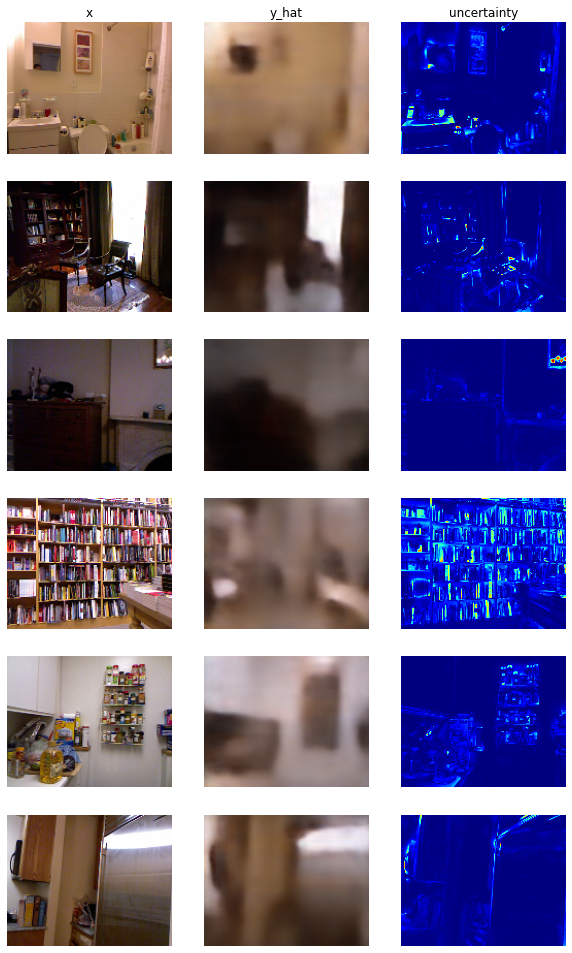

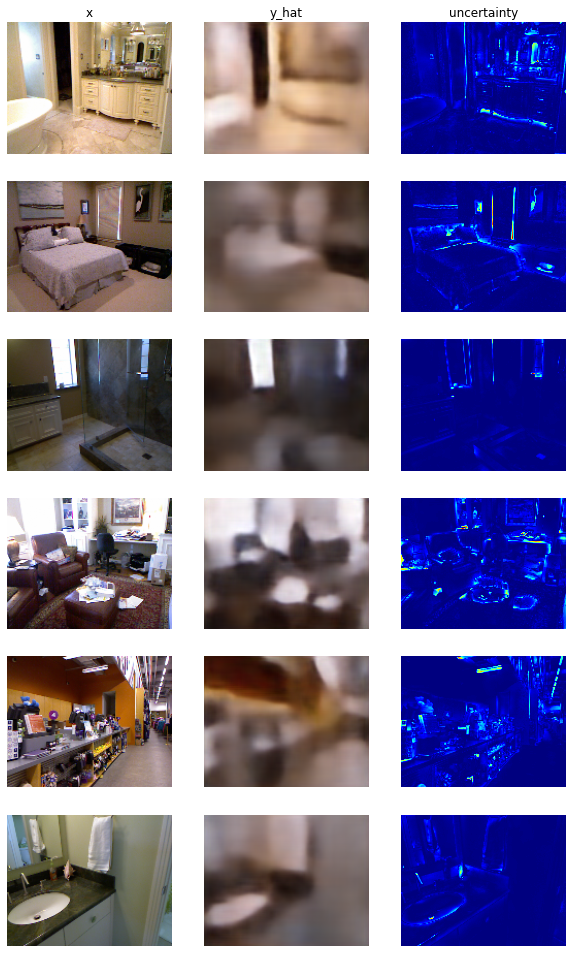

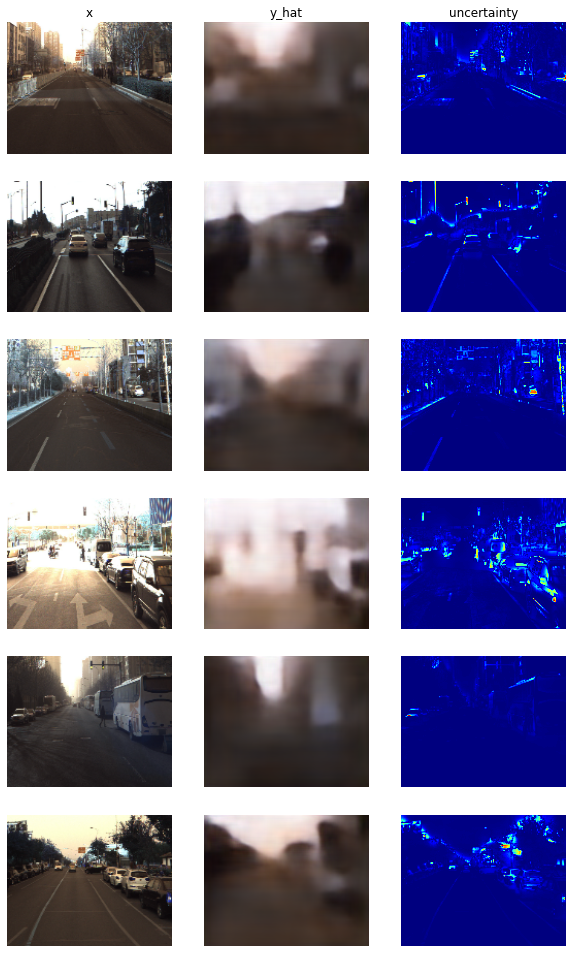

In [6]:
from utils import visualize_vae_depth_map

visualize_vae_depth_map(trained_model, ds_train, vis_path, f'trained_train', is_show=True)
visualize_vae_depth_map(trained_model, ds_test, vis_path, f'trained_test', is_show=True)
visualize_vae_depth_map(trained_model, ds_ood, vis_path, f'trained_ood', is_show=True)

## Calibration curve

In [12]:
# from visualizations import gen_calibration_plot
# gen_calibration_plot(trained_model, ds_test)

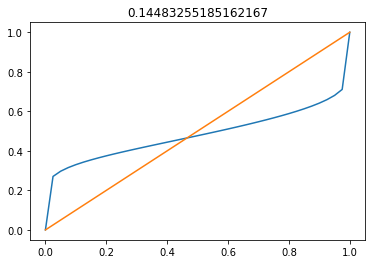

In [22]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

mu_ = []
std_ = []
y_test_ = []

for (x_test_batch, y_test_batch) in ds_test:
    y_hats = []
    for i in range(5):
        # todo-med: better use model.predict, it's more optimized
        # need training True for sampling
        y_hat, _ = trained_model(x_test_batch, training=True)
        y_hats.append(y_hat)
    y_hats = np.stack(y_hats, 0)
    mu_batch = tf.reduce_mean(y_hats, 0)
    std_batch = tf.math.reduce_std(y_hats, 0)

    mu_.append(mu_batch)
    std_.append(std_batch)
    y_test_.append(x_test_batch) # todo-high: for VAE and AE only


mu = np.concatenate(mu_) #(3029, 128, 160, 3)
std = np.concatenate(std_) #(3029, 128, 160, 3)
y_test = np.concatenate(y_test_) #(3029, 128, 160, 3)

vals = []
percentiles = np.arange(41)/40
for percentile in percentiles:
    # returns the value at the n% percentile e.g., stats.norm.ppf(0.5, 0, 1) == 0.0
    # in other words, if have a normal distrib. with mean 0 and std 1, 50% of data falls below and 50% falls above 0.0.
    ppf_for_this_percentile = stats.norm.ppf(percentile, mu, std) # (3029, 128, 160, 3)
    vals.append((y_test <= ppf_for_this_percentile).mean()) # (3029, 128, 160, 3) -> scalar

plt.plot(percentiles, vals)
plt.plot(percentiles, percentiles)
plt.title(str(np.mean(abs(percentiles - vals))))
plt.show()

## OOD comparison

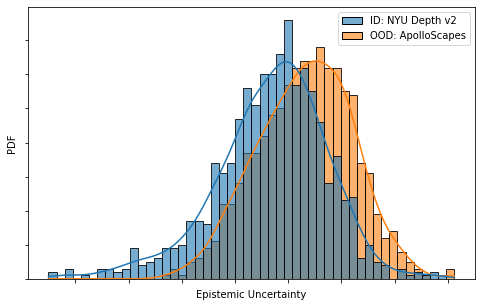

In [20]:
import os
import glob
import h5py
import seaborn as sns
import pandas as pd

def gen_ood_comparison(ds_test, ds_ood, model):
    def _itter_and_cat(ds, model):
        ds_itter = ds.as_numpy_iterator()
        l = []
        for x, y in ds_itter: # (32, 128, 160, 3), (32, 128, 160, 1)
            y_hats = []


            # y_hat, epistemic = model(x) # (32, 128, 160, 1)


            for i in range(10):
                # need training Ture for sampling
                y_hat, _ = model(x, training=True)
                y_hats.append(y_hat)
            y_hats = np.stack(y_hats, 0)
            mu_batch = tf.reduce_mean(y_hats, 0)
            std_batch = tf.math.reduce_std(y_hats, 0)
            y_hat = mu_batch
            epistemic = std_batch


            # y_hat, _ = model(x, training=False)
            # epistemic = tf.reduce_sum(tf.math.square(x - y_hat), axis=-1, keepdims=True) # (B, 128, 160, 1)


            per_sample_means = tf.reduce_mean(epistemic, axis=[1,2,3])
            l.append(per_sample_means)
        cat = tf.concat(l, axis=0)

        return cat

    iid = _itter_and_cat(ds_test, model)
    ood = _itter_and_cat(ds_ood, model)

    # make num of elements the same
    N = min(iid.shape[0], ood.shape[0])
    df = pd.DataFrame({'ID: NYU Depth v2': iid[:N], 'OOD: ApolloScapes' : ood[:N]})

    fig, ax = plt.subplots(figsize=(8, 5))
    plot = sns.histplot(data=df, kde=True, bins=50, alpha=0.6);
    plot.set(xlabel='Epistemic Uncertainty', ylabel='PDF');
    plot.set(xticklabels=[]);
    plot.set(yticklabels=[]);

gen_ood_comparison(ds_test, ds_ood, trained_model)